# Quantum analytic decent

In [5]:
#Importiere die notwendigen Packages
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import warnings

Initialisieren

In [6]:
warnings.filterwarnings("ignore")

#Setze den seed, damit die Pseudozufallsprozesse reproduzierbar ablaufen
np.random.seed(0)

Definiere ein Device mit dem Namen "dev" und zwei Qbits.
Definiere eine Quantenfunktion mit dem Argument "parameters". Auf beiden wires findet eine Rotation um die X-Achse um den Winkel parameters[0] bzw. parameters[1] statt. Die Ausgabe der Funktion sind die mit einem Pauli Z Gate ausgewerteten Wires. Die Funktion wird mit @qml.qnode() in eine QNode umgewandelt.

In [7]:
# Create a device with 2 qubits.
dev = qml.device("default.qubit", wires=2)

# Define the variational form V and observable M and combine them into a QNode.
@qml.qnode(dev, diff_method="parameter-shift", max_diff=2)
def circuit(parameters):
    qml.RX(parameters[0], wires=0)
    qml.RX(parameters[1], wires=1)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

Werte für je einen fixen Parameter (3.3 bzw. 0.5) die Funktion für den jeweils anderen Parameter aus dem Intervall [0, 2] an num-samples = 50 gleichmäßig verteilten Punkten aus.
Plotte die Ergebnisse für beide Parameter mit dem varierten Parameter theta auf der X-Achse und der Energie (Ausgabe der Funktion circuit) auf der Y-Achse.

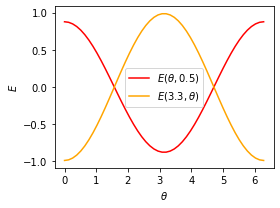

In [9]:
# Create 1D sweeps through parameter space with the other parameter fixed.
num_samples = 50

# Fix a parameter position.
parameters = np.array([3.3, 0.5], requires_grad=True)

theta_func = np.linspace(0, 2 * np.pi, num_samples)
C1 = [circuit(np.array([theta, parameters[1]])) for theta in theta_func]
C2 = [circuit(np.array([parameters[0], theta])) for theta in theta_func]

# Show the sweeps.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(theta_func, C1, label="$E(\\theta, 0.5)$", color="r")
ax.plot(theta_func, C2, label="$E(3.3, \\theta)$", color="orange")
ax.set_xlabel("$\\theta$")
ax.set_ylabel("$E$")
ax.legend()
plt.tight_layout()

In [11]:
print(circuit(np.array([1,1])))

0.2919265817264289
